In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Radial velocity fitting

In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the exellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

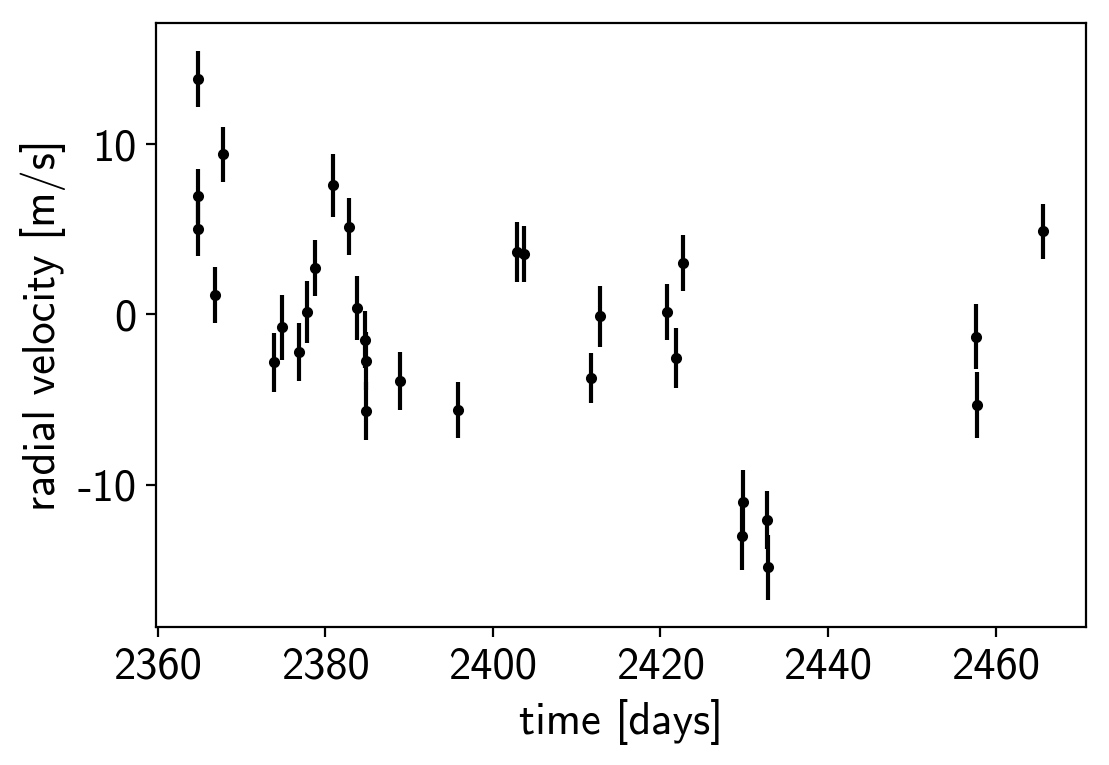

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [4]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3 (take a look at :ref:`intro-to-pymc3` if you're new to PyMC3).
First, we'll define our priors on the parameters:

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
        
    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Normal("P", mu=np.array(periods), sd=np.array(period_errs), shape=2)

    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal("logK", mu=np.log(Ks), sd=10.0, shape=2)
    
    # This is a sanity check that restricts the semiamplitude to reasonable
    # values because things can get ugly as K -> 0
    pm.Potential("logK_bound", tt.switch(logK < -2., -np.inf, 0.0))
    
    # We also want to keep period physical but this probably won't be hit
    pm.Potential("P_bound", tt.switch(P <= 0, -np.inf, 0.0))

    # Eccentricity & argument of periasteron
    ecc = pm.Uniform("ecc", lower=0, upper=0.99, shape=2,
                     testval=np.array([0.1, 0.1]))
    omega = xo.distributions.Angle("omega", shape=2, testval=np.zeros(2))
    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

Now we'll define the orbit model:

In [6]:
with model:
    
    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t0=t0,
        ecc=ecc, omega=omega)
    
    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad = orbit.get_radial_velocity(x, K=tt.exp(logK))
    pm.Deterministic("vrad", vrad)
    
    # Define the background model
    A = np.vander(x - 0.5*(x.min() + x.max()), 3)
    bkg = pm.Deterministic("bkg", tt.dot(A, trend))
    
    # Sum over planets and add the background to get the full model
    rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)

For plotting purposes, it can be useful to also save the model on a fine grid in time.

In [7]:
t = np.linspace(x.min()-5, x.max()+5, 1000)

with model:
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK))
    pm.Deterministic("vrad_pred", vrad_pred)
    A_pred = np.vander(t - 0.5*(x.min() + x.max()), 3)
    bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
    rv_model_pred = pm.Deterministic("rv_model_pred",
                                     tt.sum(vrad_pred, axis=-1) + bkg_pred)

Now, we can plot the initial model:

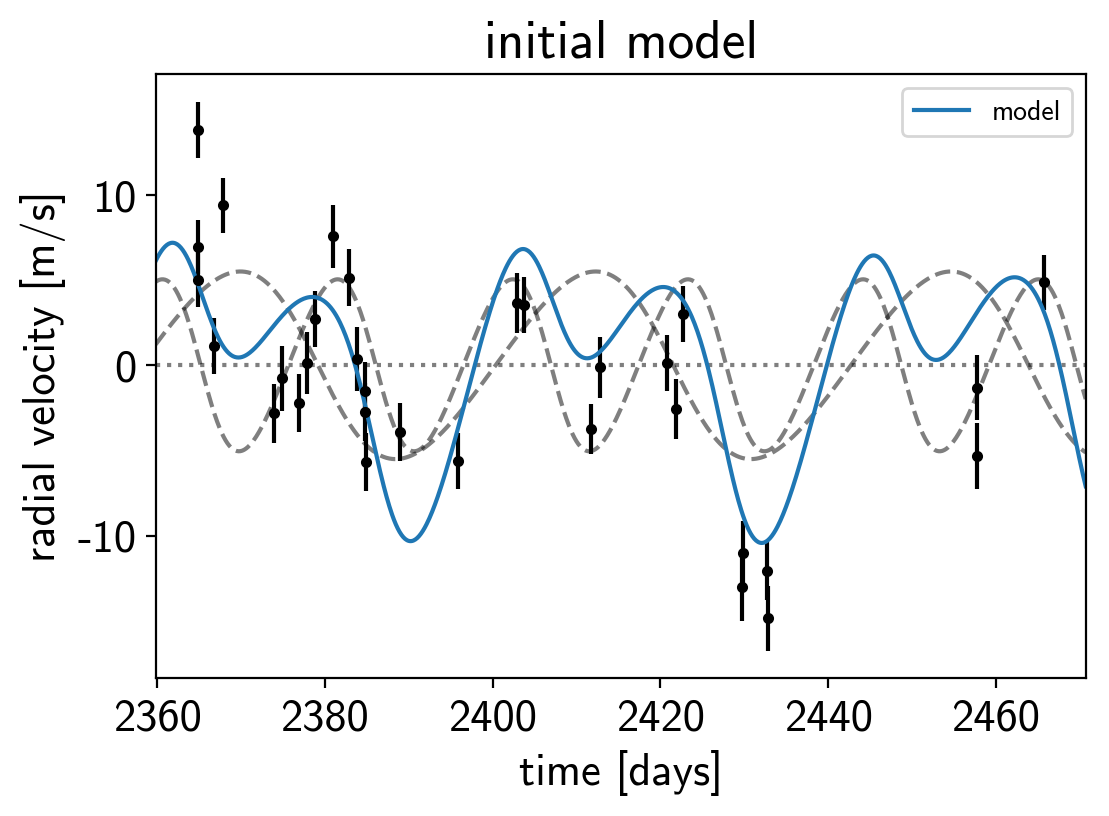

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("initial model");

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's add in the likelihood and fit for the maximum a posterior parameters.

In [9]:
with model:
    
    err = tt.sqrt(yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)
    
    map_soln = pm.find_MAP(start=model.test_point, vars=[trend])
    map_soln = pm.find_MAP(start=map_soln)

logp = -80.668, ||grad|| = 7.2169: 100%|██████████| 21/21 [00:00<00:00, 1197.85it/s] 
logp = -59.047, ||grad|| = 11.57: 100%|██████████| 2176/2176 [00:01<00:00, 1466.70it/s]


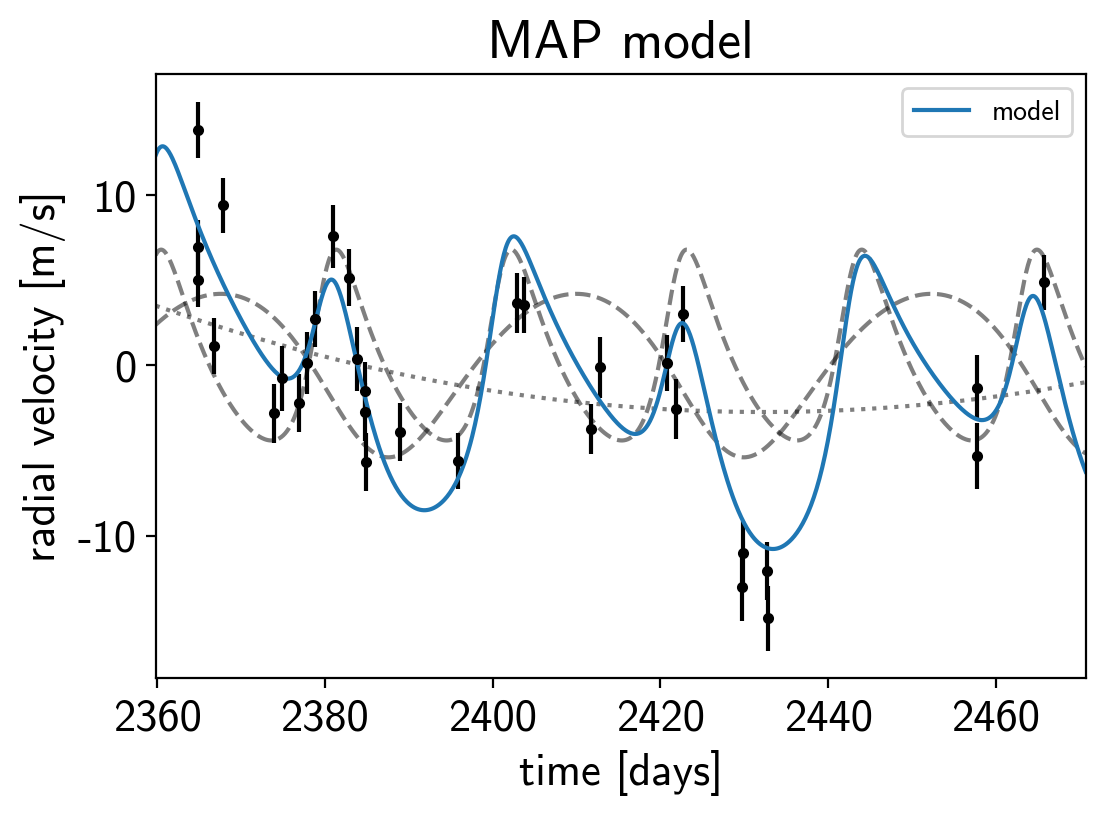

In [10]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("MAP model");

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use a :class:`exoplanet.PyMC3Sampler` to tune the sampler (see the :ref:`pymc3-extras` tutorial for more information).

In [11]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(finish=200)
with model:
    burnin = sampler.tune(tune=2500, start=model.test_point)
    trace = sampler.sample(draws=3000)

Sampling 4 chains: 100%|██████████| 1608/1608 [00:04<00:00, 340.12draws/s]
The chain contains only diverging samples. The model is probably misspecified.
Sampling 4 chains: 100%|██████████| 6608/6608 [00:16<00:00, 397.62draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [trend, logs, omega, ecc, logK, P, t0]
Sampling 4 chains: 100%|██████████| 12800/12800 [00:27<00:00, 460.69draws/s]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [12]:
pm.summary(trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
trend__0,0.000937,0.000769,0.000011,-0.000579,0.002413,4954.818624,1.000000
trend__1,-0.038581,0.023025,0.000305,-0.084751,0.005695,5929.418679,1.000270
trend__2,-1.951777,0.807705,0.010839,-3.533702,-0.374656,4884.021342,0.999880
logs,1.044249,0.224468,0.003847,0.600236,1.489714,3070.836387,1.000529
omega__0,-0.304417,0.786889,0.012632,-1.470657,1.573662,3561.756315,1.000257
omega__1,-0.630168,2.115762,0.029849,-3.133547,2.935825,4958.825223,1.000549
ecc__0,0.233891,0.111863,0.002168,0.000924,0.420804,2392.654832,1.000650
ecc__1,0.199180,0.149677,0.004537,0.000024,0.493935,993.886096,1.003839
t0__0,2072.794804,0.000702,0.000010,2072.793413,2072.796168,6014.819818,1.000091
t0__1,2082.625097,0.000400,0.000005,2082.624311,2082.625855,6931.218536,1.000032


It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

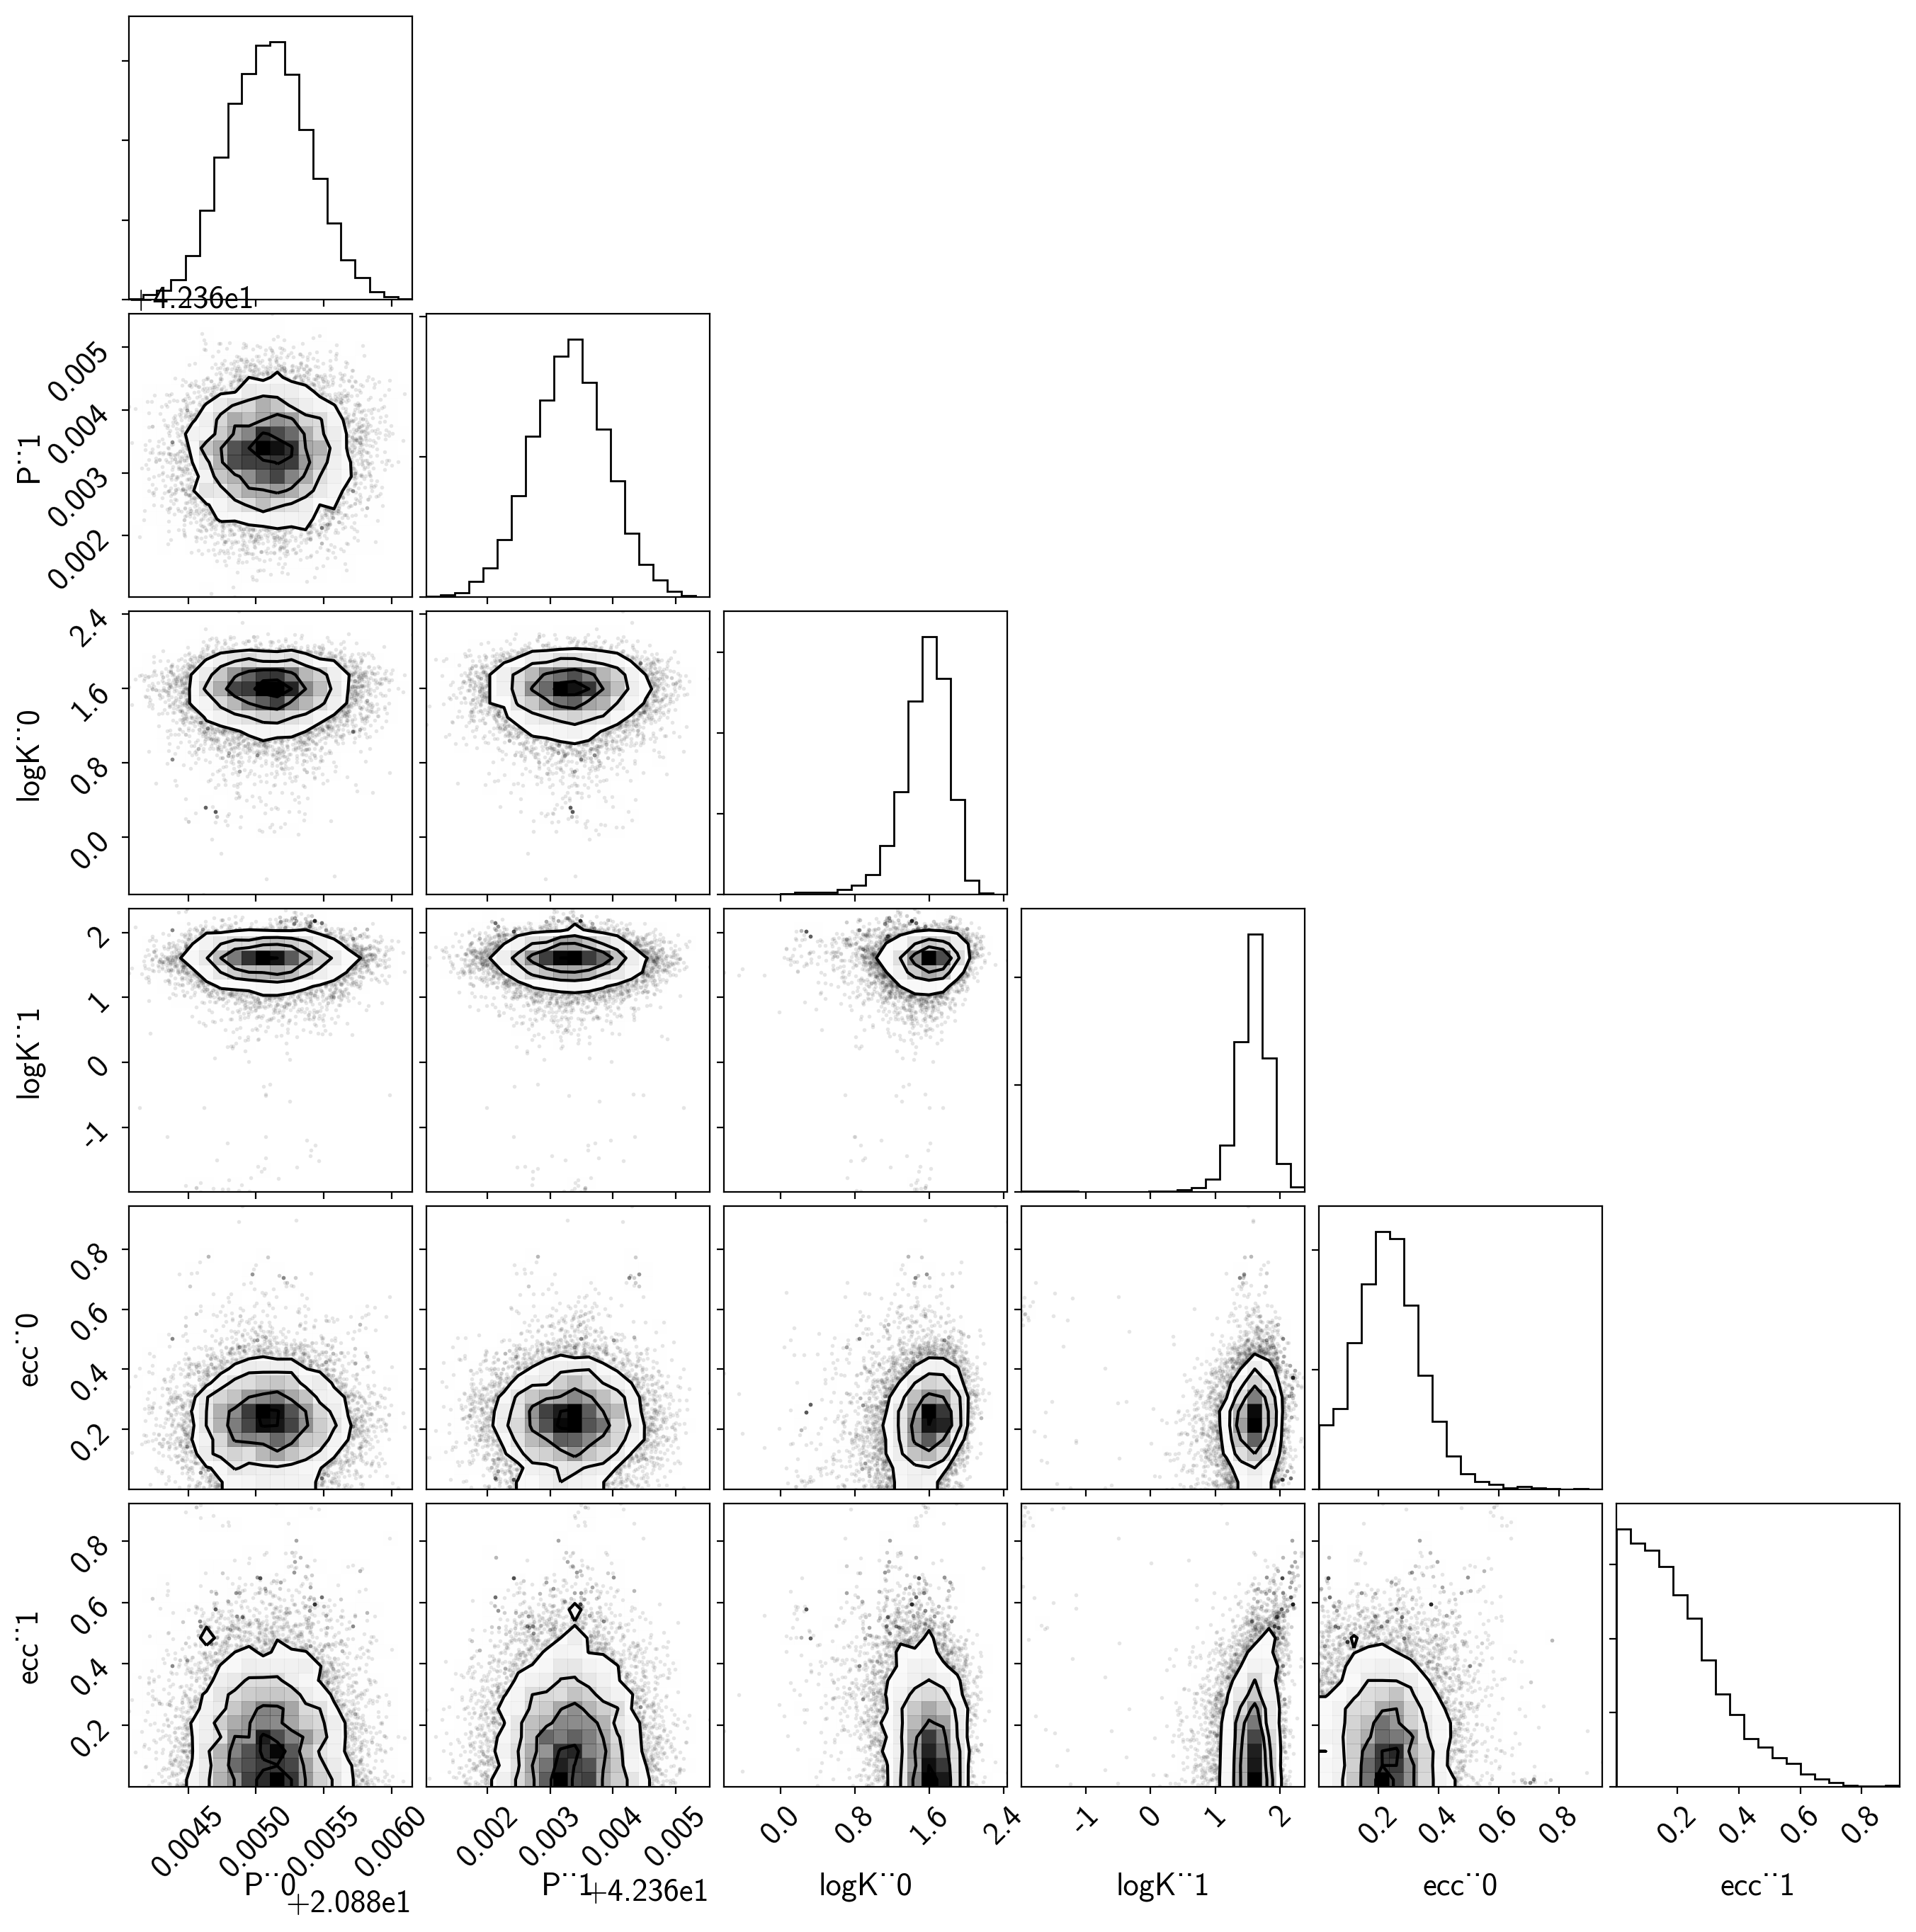

In [13]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc"])
corner.corner(samples);

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

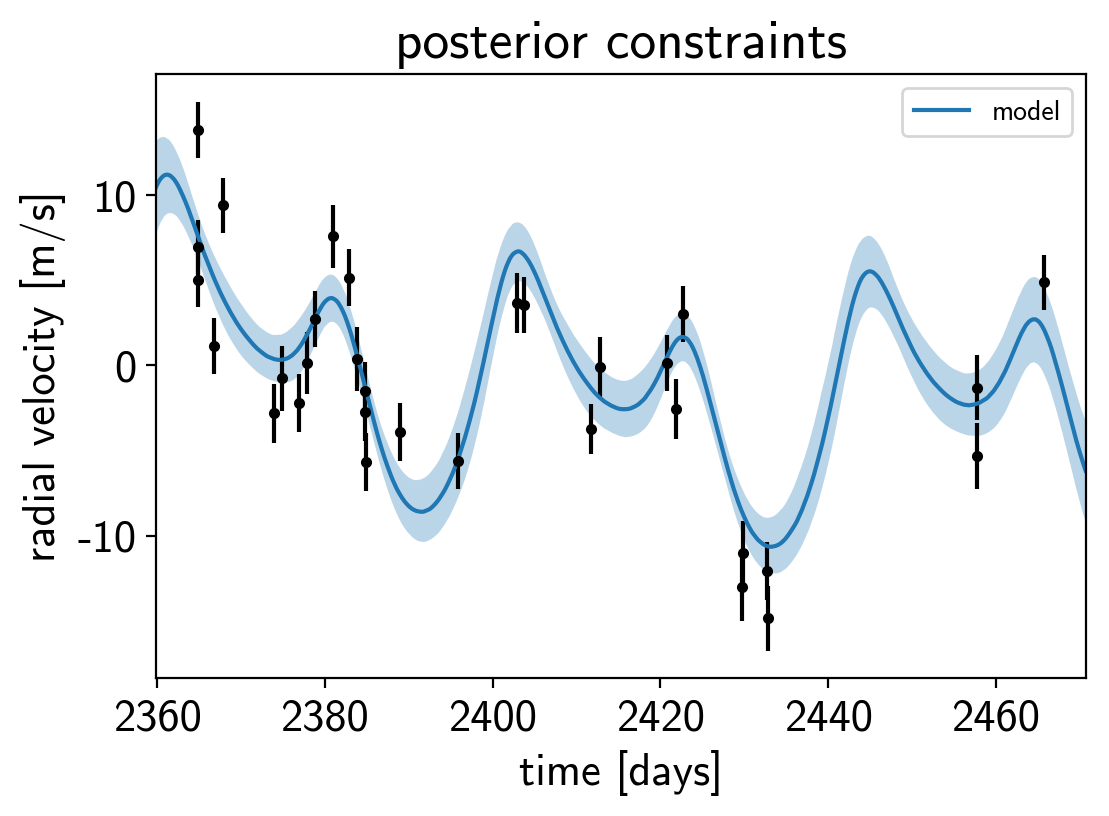

In [14]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("posterior constraints");

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

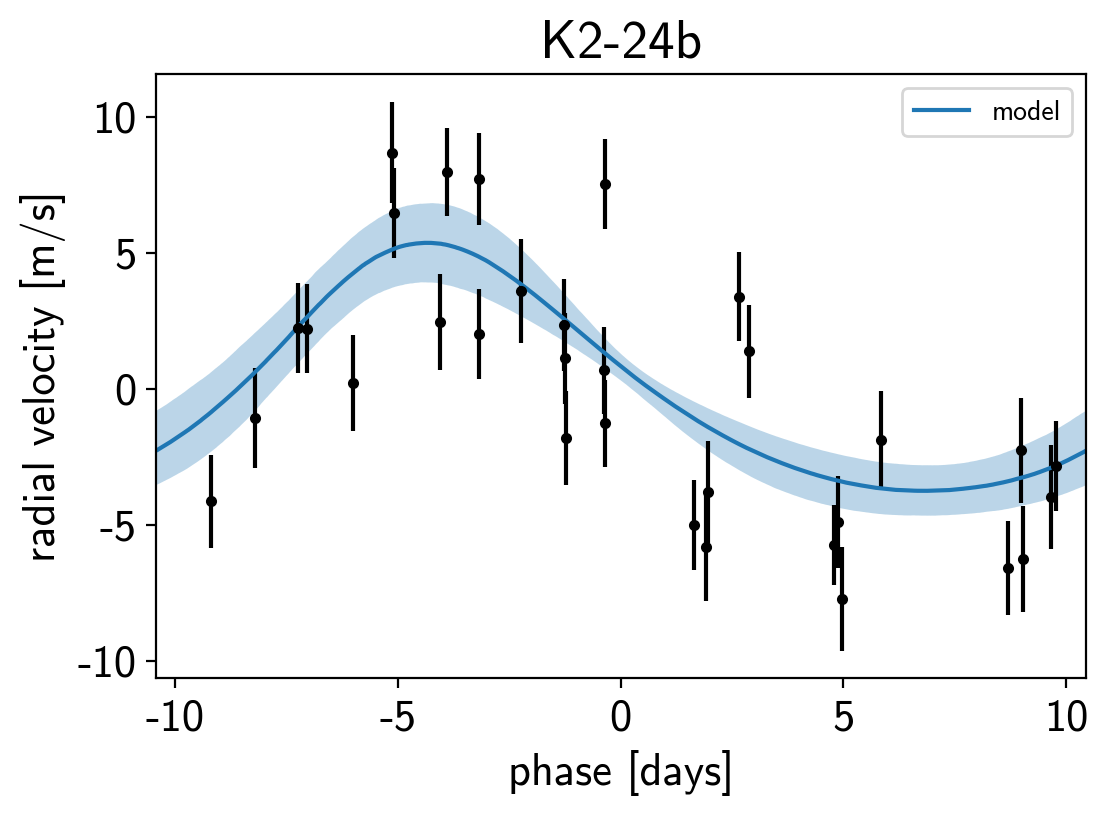

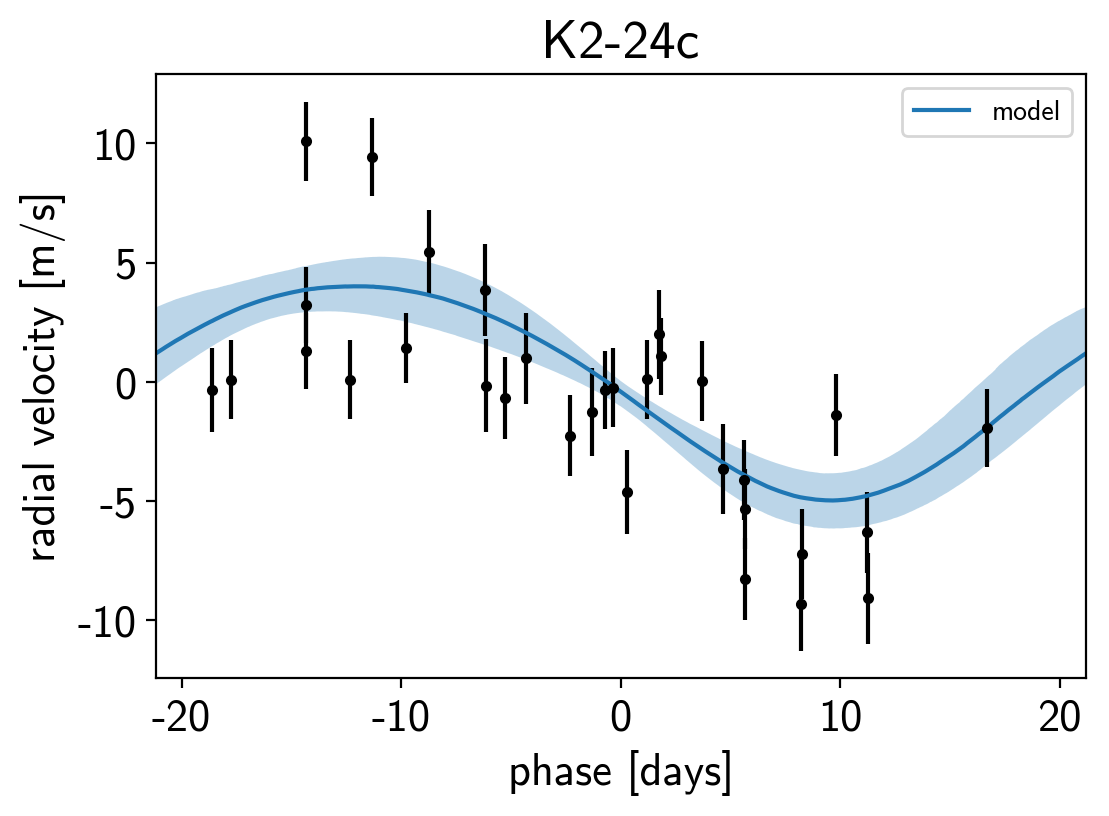

In [15]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));